# Problem Komiwojażera z użyciem symulowanego wyżarzania - sprawozdanie 
**------- Piotr Szulc 197639 ---------**

## Treść zadania
Zadanie do wykonania polega na zastosowaniu algorytmu symulowanego wyżarzania [1] do problemu komiwojażera [2] w języku python. Można korzystać z dowolnych bibliotek dostępnych w języku python. Zadanie należy oddać w formie sprawozdania z wytłumaczeniem kluczowych elementów programu (przykładowo wczytanie danych, algorytm, wizualizacja) oraz kodu źródłowego. Wyniki należy zobrazować oraz podać wnioski. Należy skorzystać z danych zamieszczonych pod adresem [3] (przykładowo xqf131), do rozpakowania danych można skorzystać z biblioteki [4].  
[1] https://www.geeksforgeeks.org/dsa/implement-simulated-annealing-in-python/  
[2] https://pl.wikipedia.org/wiki/Problem_komiwoja%C5%BCera  
[3] https://www.math.uwaterloo.ca/tsp/vlsi/index.html  
[4] https://tsplib95.readthedocs.io/en/stable/pages/usage.html  

## Wybór bibliotek

* tsplib95 - rekomendowana biblioteka do odczytywania plików .tsp.
* simanneal - mimo dużego wyboru zdecydowałem na tą bibliotekę, ponieważ skupia się na symulowanym wyżarzaniu a problem komiwojażera wymaga samodzielnej implementacji - nie jest "blackboxowy". Dodatkowo biblioteka daje dużą kontrolę nad parametrami.
* matplotlib - pokazywanie wykresów oraz map tras
* numpy - losowość oraz proste obliczenia
* inne wbudowane biblioteki do obsługi dodatkowych funkcji

### Przygotowanie
Wczytanie bibliotek

In [11]:
import tsplib95
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from simanneal import Annealer

Wczytanie plików i przygotowanie danych (możliwość wybrania pliku lub wylosowania ze zbioru)

In [12]:
def load_map(file='random'):
    if file == 'random':
        # get random TSP problem from data folder
        file = np.random.choice(os.listdir('data'))
    tsp = tsplib95.load('data/' + file)
    return tsp

tsp = load_map() # Przykładowy: xqf131.tsp

# Wczytanie danych i przygotowanie współrzędnych miast oraz funkcji odległości
cities = list(tsp.node_coords.keys())
coords = np.zeros((len(cities), 2))
for i, city in enumerate(cities):
    coords[i] = tsp.node_coords[city]

def distance(city1, city2):
    x1, y1 = tsp.node_coords[city1]
    x2, y2 = tsp.node_coords[city2]
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
random_city_nr = np.random.randint(len(cities)) - 1
print(f'Liczba miast: {len(cities)}')
print(f'Losowe współrzędne z danych: \n{coords[random_city_nr:random_city_nr+5]}')
print(f'Odległość między miastami 1 i 2 z listy wyżej: {distance(cities[random_city_nr], cities[random_city_nr + 1])}')

Liczba miast: 131
Losowe współrzędne z danych: 
[[28. 43.]
 [28. 47.]
 [32. 26.]
 [32. 31.]
 [33. 15.]]
Odległość między miastami 1 i 2 z listy wyżej: 4.0


Przygotowanie symulowanego wyżarzania oraz problemu komiwojażera.  

Źródło implementacji problemu komiwojażera: [Github: Simmaneal](https://github.com/perrygeo/simanneal/blob/master/README.md)

In [13]:
# Klasa problemu komiwojażera dla symulowanego wyżarzania
class ProblemKomiwojazera(Annealer):
    """Klasa rozwiązująca problem komiwojażera metodą symulowanego wyżarzania."""

    def __init__(self, state, distance, cities):
        self.state = state
        self.distance = distance
        self.cities = cities
        self.energy_record = []
        self.best_energy = None
        super(ProblemKomiwojazera, self).__init__(state)

    def move(self):
        '''Zamiana dwóch miast w trasie'''
        a = np.random.randint(0, len(self.state))
        b = np.random.randint(0, len(self.state))
        self.state[a], self.state[b] = self.state[b], self.state[a]

    def energy(self):
        '''Obliczenie długości trasy'''
        e = 0
        for i in range(len(self.state)):
            e += self.distance(self.cities[self.state[i - 1]], self.cities[self.state[i]])
        # Zapisuj tylko najlepszą energię dotychczas
        if self.best_energy is None or e < self.best_energy:
            self.best_energy = e
        self.energy_record.append(self.best_energy)
        return e

Uruchomienie problemu komiwojażera na danych

In [14]:
# Uruchomienie algorytmu symulowanego wyżarzania dla problemu komiwojażera

# Inicjalizacja stanu początkowego (losowa permutacja miast)
initial_state = list(range(len(cities)))
np.random.shuffle(initial_state)

# Parametry dla czterech rozwiązań
params = [
    {'Tmax': 25000.0, 'Tmin': 2.5,  'steps': 60000, 'updates': 100},
    {'Tmax': 25000.0, 'Tmin': 5.0,  'steps': 120000,  'updates': 100},
    {'Tmax': 10000.0, 'Tmin': 10.0, 'steps': 80000,  'updates': 100},
    {'Tmax': 10000.0,  'Tmin': 20.0, 'steps':120000,  'updates': 100} ]

solvers = []
states = []
energies = []
times = []

for i, param in enumerate(params):
    solver = ProblemKomiwojazera(state=initial_state.copy(), distance=distance, cities=cities)
    solver.Tmax = param['Tmax']
    solver.Tmin = param['Tmin']
    solver.steps = param['steps']
    solver.updates = param['updates']
    start = time.time()
    print(f'Uruchamianie problemu {i+1}')
    state, energy = solver.anneal()
    end = time.time()
    print(f'Zakończono problem {i+1}')
    solvers.append(solver)
    states.append(state)
    energies.append(energy)
    times.append(end - start)
    print(f'Problem {i+1}: energia={energy}, czas={end-start}s\n')

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 20794.09428       4691.97   100.00%    48.33%     0:00:00     0:00:08

Uruchamianie problemu 1


     2.50000       1454.56     6.17%     2.17%     0:00:08     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 22958.85941       4538.87   100.00%    50.33%     0:00:00     0:00:15

Zakończono problem 1
Problem 1: energia=1450.7978628063117, czas=8.262970447540283s

Uruchamianie problemu 2


     5.00000       1426.33     7.92%     4.08%     0:00:16     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
  8709.63590       4734.12    99.62%    50.62%     0:00:00     0:00:10

Zakończono problem 2
Problem 2: energia=1424.1369958235994, czas=16.047375917434692s

Uruchamianie problemu 3


    10.00000       2105.44    20.00%     9.88%     0:00:10     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
  9397.45598       4478.75    99.75%    50.00%     0:00:00     0:00:14

Zakończono problem 3
Problem 3: energia=2025.8175227550907, czas=10.489711999893188s

Uruchamianie problemu 4


    20.00000       2708.84    34.50%    17.08%     0:00:16     0:00:00

Zakończono problem 4
Problem 4: energia=2450.5757101213107, czas=15.561429262161255s



Wizualizacja danych

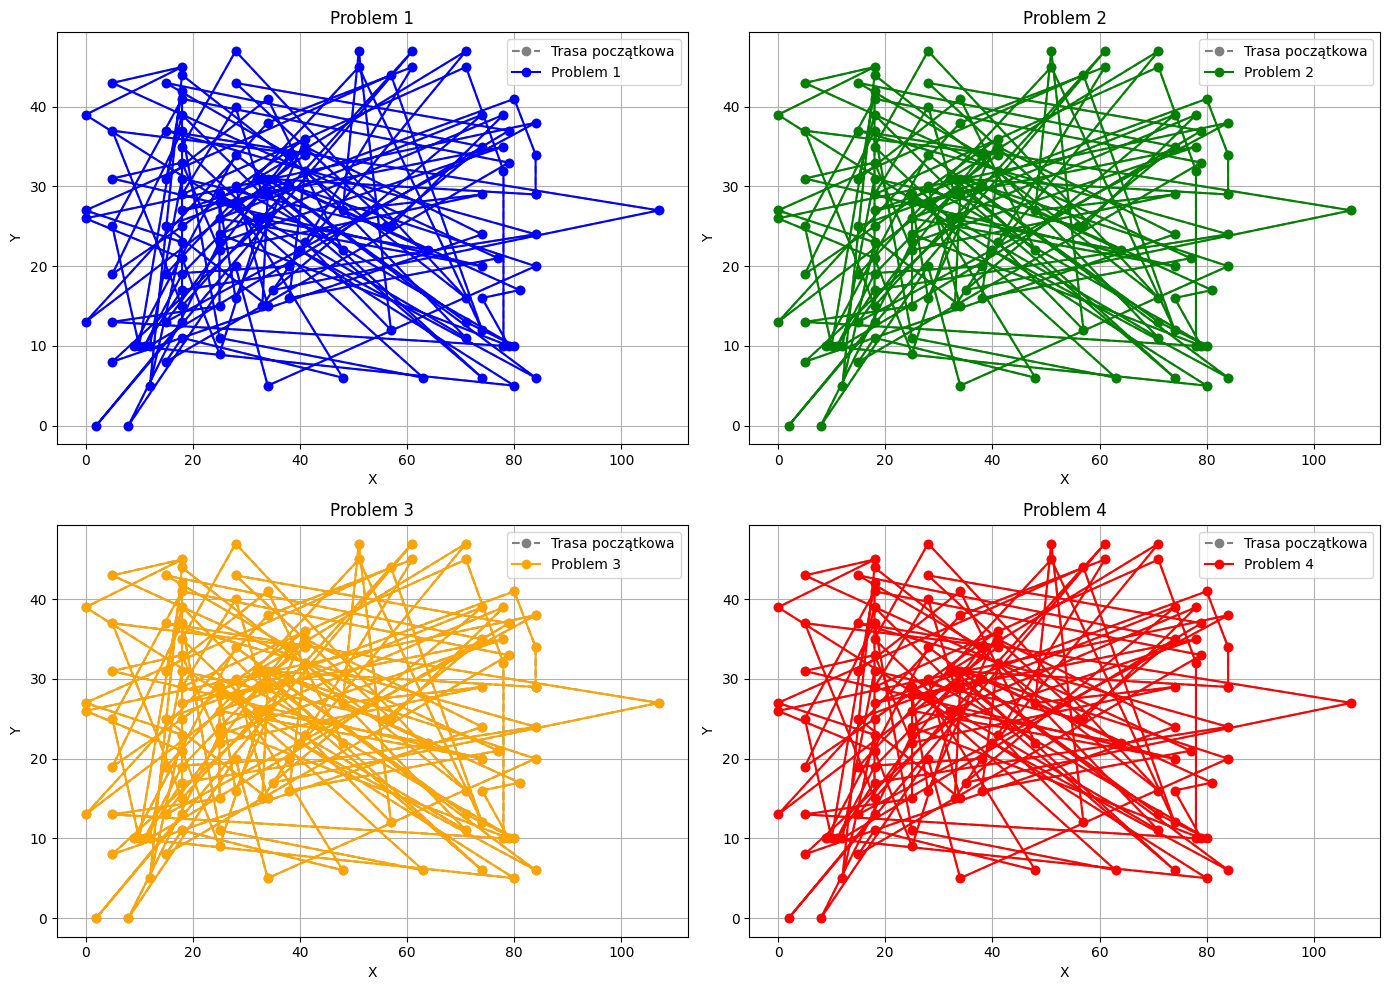

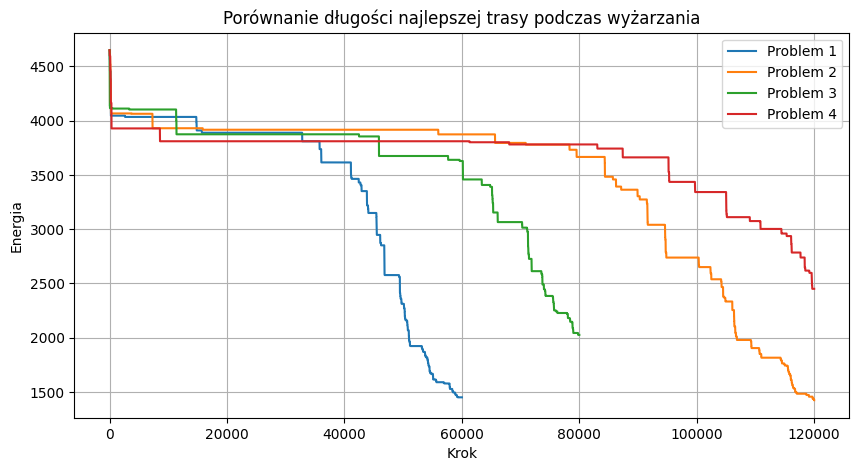

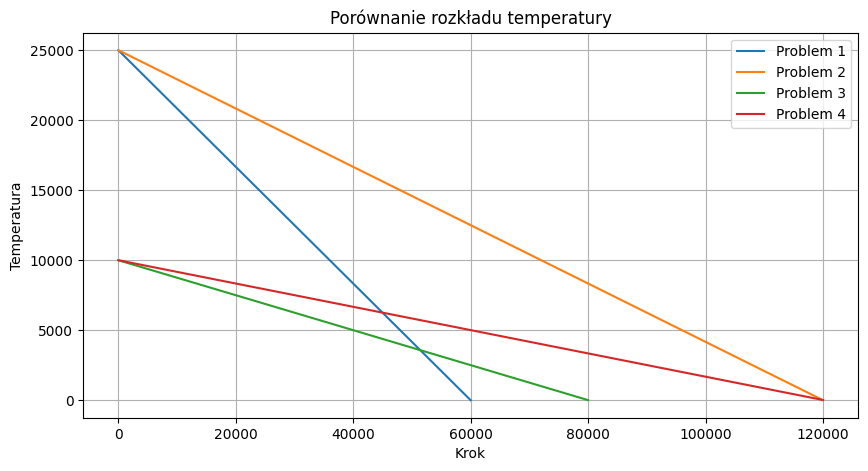

In [15]:
# Wizualizacja trasy oraz energii w czasie dla problemu komiwojażera

# --- Wizualizacja tras czterech rozwiązań ---
def plot_tour(coords, state, title='Trasa', color='blue'):
    plt.plot(coords[state + [state[0]], 0], coords[state + [state[0]], 1], 'o-', color=color, label=title)

def compare_all_tours(coords, initial_state, states, titles=None, colors=None):
    import matplotlib.pyplot as plt
    n = len(states)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    if titles is None:
        titles = [f'Problem {i+1}' for i in range(n)]
    if colors is None:
        colors = ['blue', 'green', 'orange', 'red']
    for i, state in enumerate(states):
        ax = axes[i]
        # Trasa początkowa (szara)
        ax.plot(coords[initial_state + [initial_state[0]], 0], coords[initial_state + [initial_state[0]], 1], 'o--', color='gray', label='Trasa początkowa')
        # Trasa po wyżarzaniu
        ax.plot(coords[state + [state[0]], 0], coords[state + [state[0]], 1], 'o-', color=colors[i % len(colors)], label=titles[i])
        ax.set_title(titles[i])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.legend()
        ax.grid(True)
    plt.tight_layout()
    plt.show()

# Porównanie energii (długości trasy) w czasie
def compare_all_energies(problems, labels=None):
    plt.figure(figsize=(10, 5))
    if labels is None:
        labels = [f'Problem {i+1}' for i in range(len(problems))]
    for i, problem in enumerate(problems):
        if hasattr(problem, 'energy_record') and problem.energy_record:
            plt.plot(problem.energy_record, label=labels[i])
    plt.xlabel('Krok')
    plt.ylabel('Energia')
    plt.title('Porównanie długości najlepszej trasy podczas wyżarzania')
    plt.legend()
    plt.grid(True)
    plt.show()

# Porównanie rozkładu temperatury
def compare_all_temperatures(Tmax_list, Tmin_list, steps_list, labels=None):
    plt.figure(figsize=(10, 5))
    if labels is None:
        labels = [f'Problem {i+1}' for i in range(len(Tmax_list))]
    for i in range(len(Tmax_list)):
        Tmax = Tmax_list[i]
        Tmin = Tmin_list[i]
        steps = steps_list[i]
        T = [Tmax - (Tmax - Tmin) * (j / steps) for j in range(steps + 1)]
        plt.plot(T, label=labels[i])
    plt.xlabel('Krok')
    plt.ylabel('Temperatura')
    plt.title('Porównanie rozkładu temperatury')
    plt.legend()
    plt.grid(True)
    plt.show()

# 1. Porównanie tras
labels = ["Problem 1", "Problem 2", "Problem 3", "Problem 4"]
compare_all_tours(coords, initial_state, states, titles=labels)

# 2. Porównanie energii
compare_all_energies(solvers, labels=labels)

# 3. Porównanie rozkładu temperatury
compare_all_temperatures([p.Tmax for p in solvers],
                        [p.Tmin for p in solvers],
                        [p.steps for p in solvers],
                        labels=labels)

## Wnioski

- Najlepszy wynik dał problem, gdzie była wyższe Tmax, niższe Tmin oraz największa ilosć kroków. Daje to wniosek, że duży wpływ ma większa początkowa losowość oraz czas trwania wyżarzania
- Każdy wynik wykazuje podobną dynamikę: na początku droga (energia) gwałtownie spada, się utrzymuje a potem zaczyna spadać.
- Wyniki są wciąż dalekie od optymalnych wg źródła danych, dlatego algorytm wymaga jeszcze optymalizacji.